## CP2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [2]:
data = pd.read_excel(r"C:\Users\HARSH\Desktop\Capstone Project\Customer_Churn_Data_Large (6).xlsx")
data.head()


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel
0,1,62,M,Single,Low
1,2,65,M,Married,Low
2,3,18,M,Single,Low
3,4,21,M,Widowed,Low
4,5,21,M,Divorced,Medium


In [3]:
import pandas as pd

# Step 1: Load the Excel file
file_path = r"C:\Users\HARSH\Desktop\Capstone Project\Customer_Churn_Data_Large (6).xlsx"
xls = pd.ExcelFile(file_path)

# Step 2: Read individual sheets
demographics = pd.read_excel(xls, sheet_name="Customer_Demographics")
transactions = pd.read_excel(xls, sheet_name="Transaction_History")
service = pd.read_excel(xls, sheet_name="Customer_Service")
online = pd.read_excel(xls, sheet_name="Online_Activity")
churn = pd.read_excel(xls, sheet_name="Churn_Status")

# Step 3: Merge all sheets on 'CustomerID'
data = demographics.merge(transactions, on='CustomerID', how='left')\
                   .merge(service, on='CustomerID', how='left')\
                   .merge(online, on='CustomerID', how='left')\
                   .merge(churn, on='CustomerID', how='left')

# Step 4: Verify
print("Shape:", data.shape)
print(data.head())


Shape: (6812, 17)
   CustomerID  Age Gender MaritalStatus IncomeLevel  TransactionID  \
0           1   62      M        Single         Low           7194   
1           2   65      M       Married         Low           7250   
2           2   65      M       Married         Low           9660   
3           2   65      M       Married         Low           2998   
4           2   65      M       Married         Low           1228   

  TransactionDate  AmountSpent ProductCategory  InteractionID InteractionDate  \
0      2022-03-27       416.50     Electronics         6363.0      2022-03-31   
1      2022-08-08        54.96        Clothing         3329.0      2022-03-17   
2      2022-07-25       197.50     Electronics         3329.0      2022-03-17   
3      2022-01-25       101.31       Furniture         3329.0      2022-03-17   
4      2022-07-24       397.37        Clothing         3329.0      2022-03-17   

  InteractionType ResolutionStatus LastLoginDate  LoginFrequency ServiceUs

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        6812 non-null   int64         
 1   Age               6812 non-null   int64         
 2   Gender            6812 non-null   object        
 3   MaritalStatus     6812 non-null   object        
 4   IncomeLevel       6812 non-null   object        
 5   TransactionID     6812 non-null   int64         
 6   TransactionDate   6812 non-null   datetime64[ns]
 7   AmountSpent       6812 non-null   float64       
 8   ProductCategory   6812 non-null   object        
 9   InteractionID     5204 non-null   float64       
 10  InteractionDate   5204 non-null   datetime64[ns]
 11  InteractionType   5204 non-null   object        
 12  ResolutionStatus  5204 non-null   object        
 13  LastLoginDate     6812 non-null   datetime64[ns]
 14  LoginFrequency    6812 n

In [5]:
#  1. Data Cleaning

In [6]:
# View basic info
print(data.info())

# Check missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        6812 non-null   int64         
 1   Age               6812 non-null   int64         
 2   Gender            6812 non-null   object        
 3   MaritalStatus     6812 non-null   object        
 4   IncomeLevel       6812 non-null   object        
 5   TransactionID     6812 non-null   int64         
 6   TransactionDate   6812 non-null   datetime64[ns]
 7   AmountSpent       6812 non-null   float64       
 8   ProductCategory   6812 non-null   object        
 9   InteractionID     5204 non-null   float64       
 10  InteractionDate   5204 non-null   datetime64[ns]
 11  InteractionType   5204 non-null   object        
 12  ResolutionStatus  5204 non-null   object        
 13  LastLoginDate     6812 non-null   datetime64[ns]
 14  LoginFrequency    6812 n

* Interaction-related columns (InteractionID, InteractionDate, InteractionType, ResolutionStatus) have 1,608 missing values, 
likely because not all customers contacted customer service.

* These missing values are not errors — they represent customers who never interacted with support.

In [7]:
# Step 1: Create a binary indicator for customer service interaction
data['HadInteraction'] = data['InteractionID'].notnull().astype(int)

# Step 2: Fill missing interaction details
data['InteractionType'] = data['InteractionType'].fillna('None')
data['ResolutionStatus'] = data['ResolutionStatus'].fillna('None')

# Optional: Drop unnecessary ID/date columns
data.drop(columns=['InteractionID', 'InteractionDate'], inplace=True)


In [8]:
data.isnull().sum()

CustomerID          0
Age                 0
Gender              0
MaritalStatus       0
IncomeLevel         0
TransactionID       0
TransactionDate     0
AmountSpent         0
ProductCategory     0
InteractionType     0
ResolutionStatus    0
LastLoginDate       0
LoginFrequency      0
ServiceUsage        0
ChurnStatus         0
HadInteraction      0
dtype: int64

In [9]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Apply to selected columns
for col in ['Age', 'AmountSpent', 'LoginFrequency']:
    outliers = detect_outliers_iqr(data, col)
    print(f"{col}: {len(outliers)} outliers")


Age: 0 outliers
AmountSpent: 0 outliers
LoginFrequency: 0 outliers


In [10]:
# Find duplicate rows
duplicates = data[data.duplicated()]

# Display the duplicates
print(f"Total duplicate rows: {duplicates.shape[0]}")
display(duplicates)


Total duplicate rows: 282


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TransactionID,TransactionDate,AmountSpent,ProductCategory,InteractionType,ResolutionStatus,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus,HadInteraction
114,16,30,F,Single,Medium,9620,2022-11-25,52.67,Books,Inquiry,Resolved,2023-03-15,41,Online Banking,1,1
116,16,30,F,Single,Medium,5751,2022-07-23,352.99,Books,Inquiry,Resolved,2023-03-15,41,Online Banking,1,1
118,16,30,F,Single,Medium,3844,2022-11-22,250.51,Furniture,Inquiry,Resolved,2023-03-15,41,Online Banking,1,1
120,16,30,F,Single,Medium,6371,2022-11-14,154.70,Books,Inquiry,Resolved,2023-03-15,41,Online Banking,1,1
122,16,30,F,Single,Medium,4438,2022-08-09,470.53,Clothing,Inquiry,Resolved,2023-03-15,41,Online Banking,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6779,994,35,F,Single,Medium,5358,2022-09-06,326.62,Books,Complaint,Unresolved,2023-07-23,25,Mobile App,0,1
6781,994,35,F,Single,Medium,7232,2022-12-16,336.21,Groceries,Complaint,Unresolved,2023-07-23,25,Mobile App,0,1
6783,994,35,F,Single,Medium,9781,2022-03-06,125.20,Electronics,Complaint,Unresolved,2023-07-23,25,Mobile App,0,1
6785,994,35,F,Single,Medium,9661,2022-05-16,143.23,Electronics,Complaint,Unresolved,2023-07-23,25,Mobile App,0,1


In [11]:
display(duplicates)

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TransactionID,TransactionDate,AmountSpent,ProductCategory,InteractionType,ResolutionStatus,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus,HadInteraction
114,16,30,F,Single,Medium,9620,2022-11-25,52.67,Books,Inquiry,Resolved,2023-03-15,41,Online Banking,1,1
116,16,30,F,Single,Medium,5751,2022-07-23,352.99,Books,Inquiry,Resolved,2023-03-15,41,Online Banking,1,1
118,16,30,F,Single,Medium,3844,2022-11-22,250.51,Furniture,Inquiry,Resolved,2023-03-15,41,Online Banking,1,1
120,16,30,F,Single,Medium,6371,2022-11-14,154.70,Books,Inquiry,Resolved,2023-03-15,41,Online Banking,1,1
122,16,30,F,Single,Medium,4438,2022-08-09,470.53,Clothing,Inquiry,Resolved,2023-03-15,41,Online Banking,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6779,994,35,F,Single,Medium,5358,2022-09-06,326.62,Books,Complaint,Unresolved,2023-07-23,25,Mobile App,0,1
6781,994,35,F,Single,Medium,7232,2022-12-16,336.21,Groceries,Complaint,Unresolved,2023-07-23,25,Mobile App,0,1
6783,994,35,F,Single,Medium,9781,2022-03-06,125.20,Electronics,Complaint,Unresolved,2023-07-23,25,Mobile App,0,1
6785,994,35,F,Single,Medium,9661,2022-05-16,143.23,Electronics,Complaint,Unresolved,2023-07-23,25,Mobile App,0,1


Gender
F    52.554316
M    47.445684
Name: proportion, dtype: float64


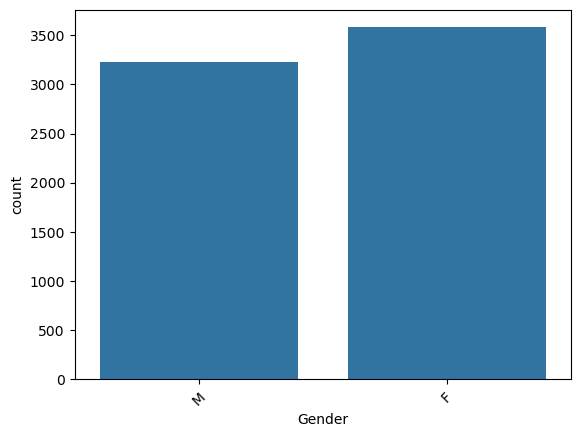

MaritalStatus
Widowed     27.833235
Divorced    26.321198
Married     23.414563
Single      22.431004
Name: proportion, dtype: float64


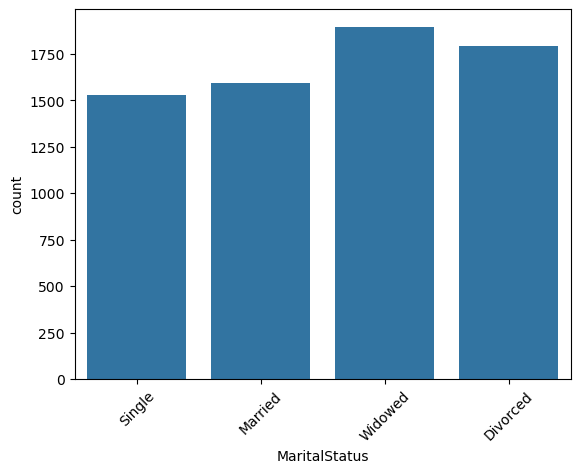

IncomeLevel
High      34.351145
Medium    33.250147
Low       32.398708
Name: proportion, dtype: float64


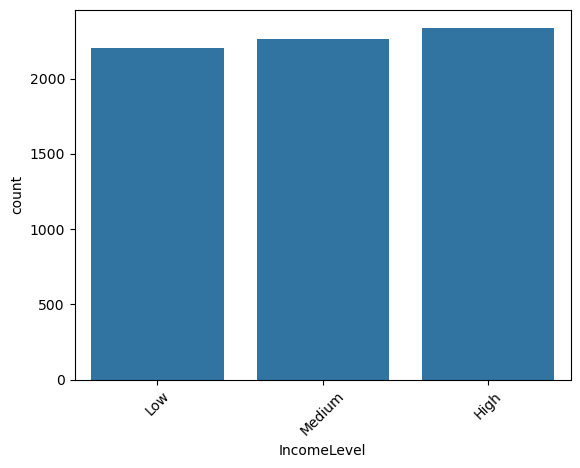

ProductCategory
Books          20.669407
Electronics    20.052848
Groceries      20.052848
Clothing       19.788608
Furniture      19.436289
Name: proportion, dtype: float64


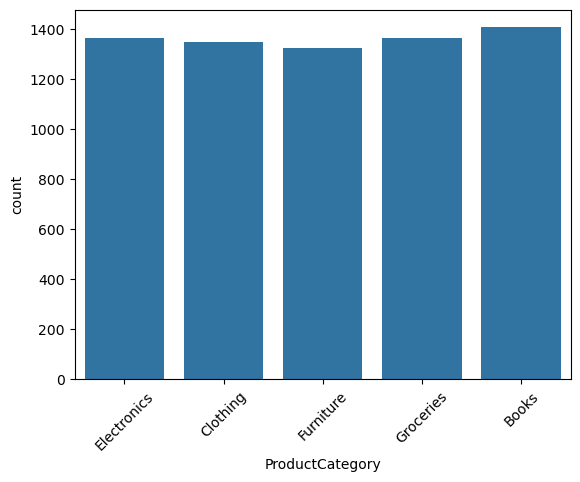

ServiceUsage
Online Banking    35.510863
Mobile App        33.367587
Website           31.121550
Name: proportion, dtype: float64


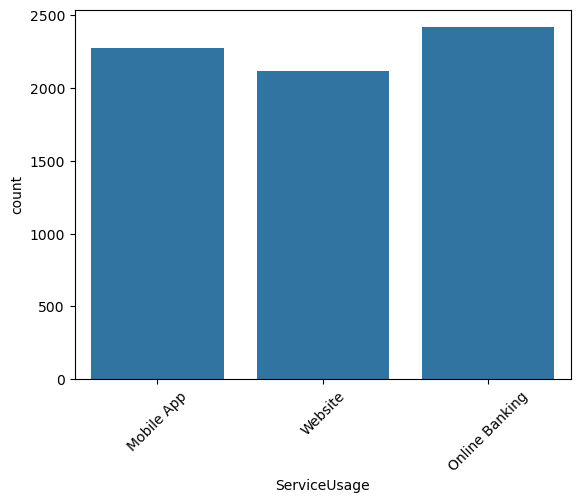

ResolutionStatus
Resolved      39.533177
Unresolved    36.861421
None          23.605402
Name: proportion, dtype: float64


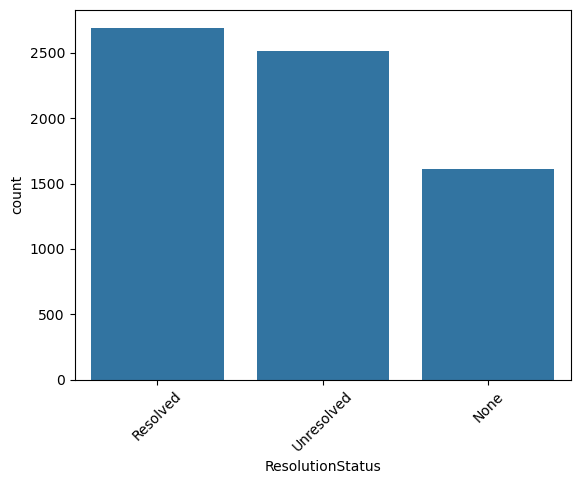

InteractionType
Feedback     28.200235
Complaint    25.968878
None         23.605402
Inquiry      22.225484
Name: proportion, dtype: float64


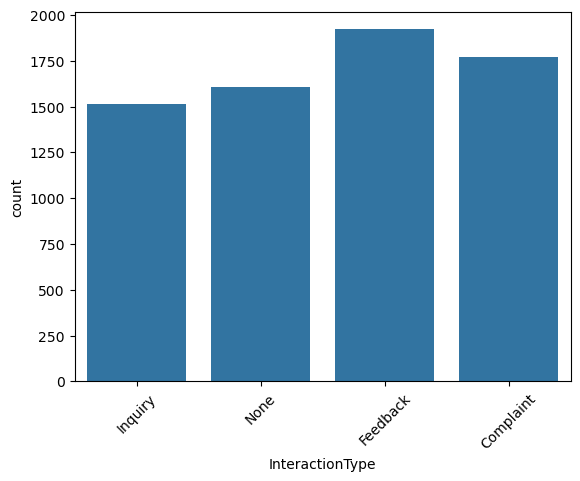

In [12]:
for col in ['Gender', 'MaritalStatus', 'IncomeLevel', 'ProductCategory', 'ServiceUsage', 'ResolutionStatus', 'InteractionType']:
    print(data[col].value_counts(normalize=True)*100)
    sns.countplot(x=col, data=data)
    plt.xticks(rotation=45)
    plt.show()


<Axes: xlabel='Age', ylabel='Count'>

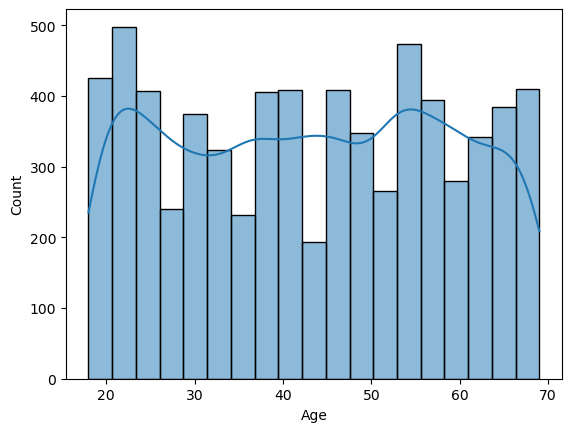

In [13]:
data[['Age', 'AmountSpent',  'LoginFrequency']].describe()
sns.histplot(data['Age'], kde=True)


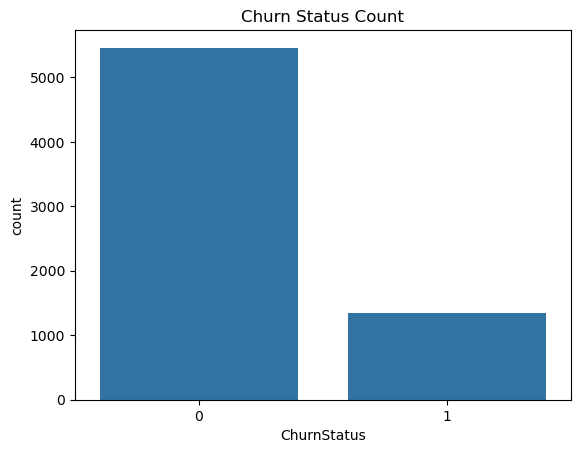

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='ChurnStatus', data=data)
plt.title("Churn Status Count")
plt.show()


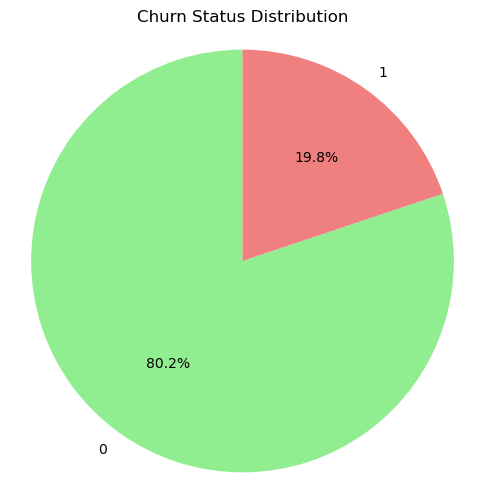

In [15]:
# Get churn value counts
churn_counts = data['ChurnStatus'].value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
plt.title('Churn Status Distribution')
plt.axis('equal')  
plt.show()


<Axes: xlabel='ChurnStatus', ylabel='AmountSpent'>

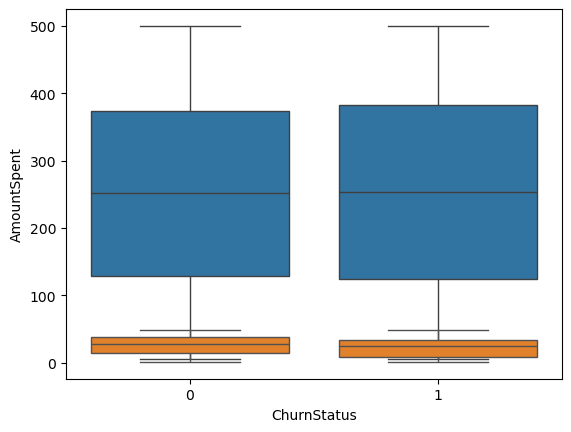

In [16]:
sns.boxplot(x='ChurnStatus', y='AmountSpent', data=data)
sns.boxplot(x='ChurnStatus', y='LoginFrequency', data=data)


<Axes: xlabel='Gender', ylabel='count'>

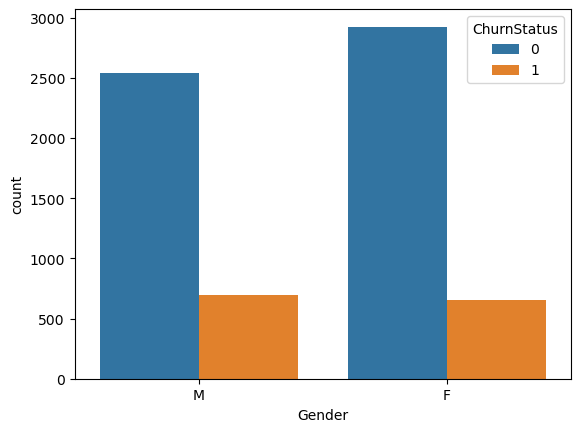

In [17]:
pd.crosstab(data['Gender'], data['ChurnStatus'], normalize='index') * 100
sns.countplot(x='Gender', hue='ChurnStatus', data=data)


<Axes: xlabel='Month', ylabel='count'>

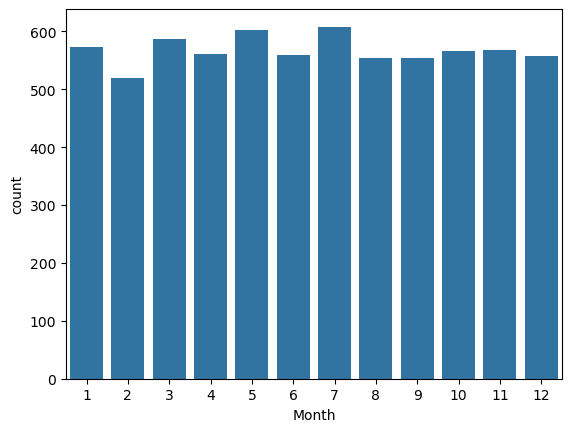

In [18]:
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['Month'] = data['TransactionDate'].dt.month
data['Weekday'] = data['TransactionDate'].dt.day_name()

sns.countplot(x='Month', data=data)


<Axes: >

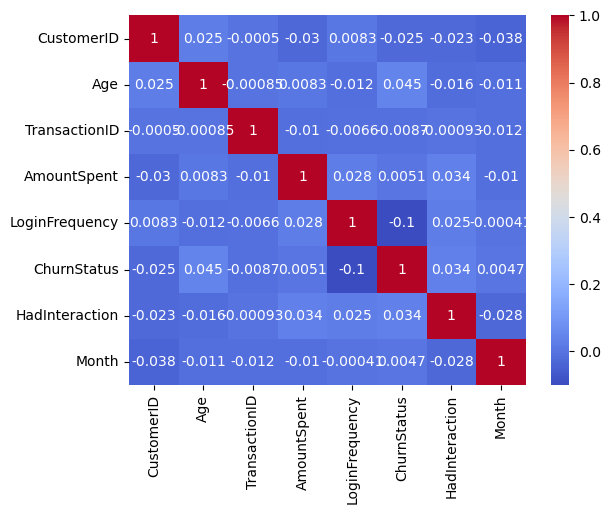

In [19]:
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')


In [20]:
data= data.drop('CustomerID',axis=1)

In [21]:
# Loop through all categorical columns and display value counts
cat_cols = data.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    print(f"\n--- {col} ---")
    print(data[col].value_counts(dropna=False))



--- Gender ---
Gender
F    3580
M    3232
Name: count, dtype: int64

--- MaritalStatus ---
MaritalStatus
Widowed     1896
Divorced    1793
Married     1595
Single      1528
Name: count, dtype: int64

--- IncomeLevel ---
IncomeLevel
High      2340
Medium    2265
Low       2207
Name: count, dtype: int64

--- ProductCategory ---
ProductCategory
Books          1408
Electronics    1366
Groceries      1366
Clothing       1348
Furniture      1324
Name: count, dtype: int64

--- InteractionType ---
InteractionType
Feedback     1921
Complaint    1769
None         1608
Inquiry      1514
Name: count, dtype: int64

--- ResolutionStatus ---
ResolutionStatus
Resolved      2693
Unresolved    2511
None          1608
Name: count, dtype: int64

--- ServiceUsage ---
ServiceUsage
Online Banking    2419
Mobile App        2273
Website           2120
Name: count, dtype: int64

--- Weekday ---
Weekday
Monday       1044
Tuesday      1027
Wednesday     978
Thursday      949
Sunday        946
Friday        935
S

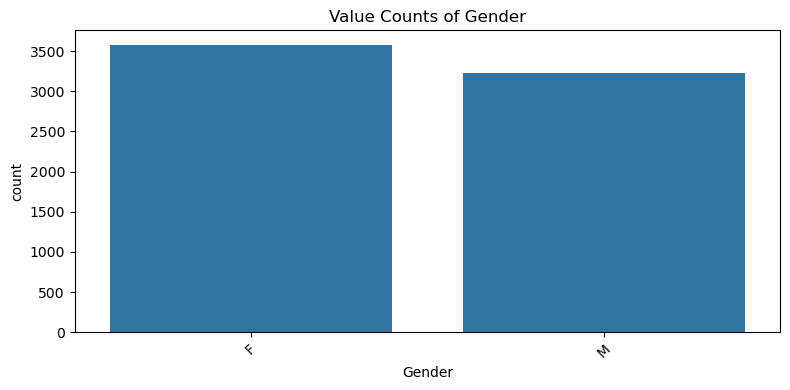

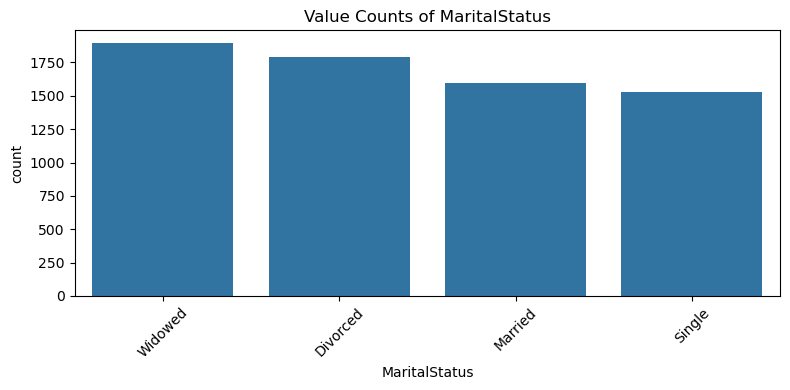

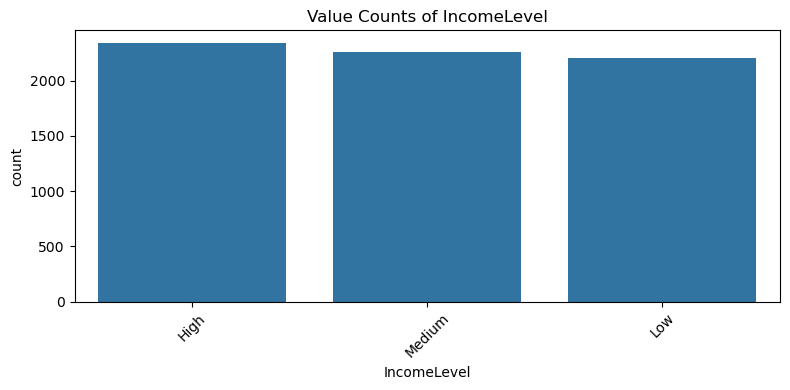

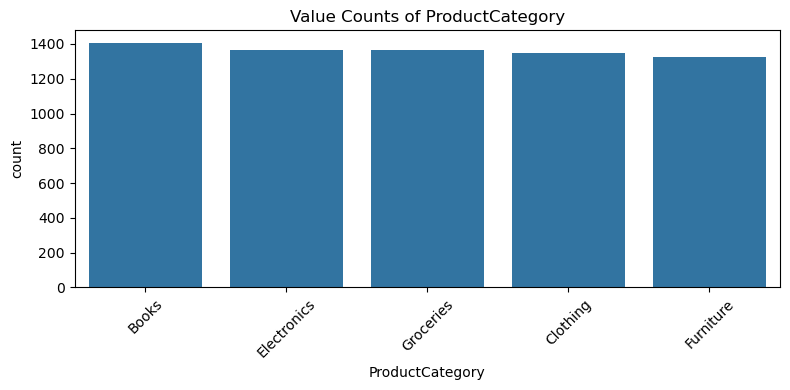

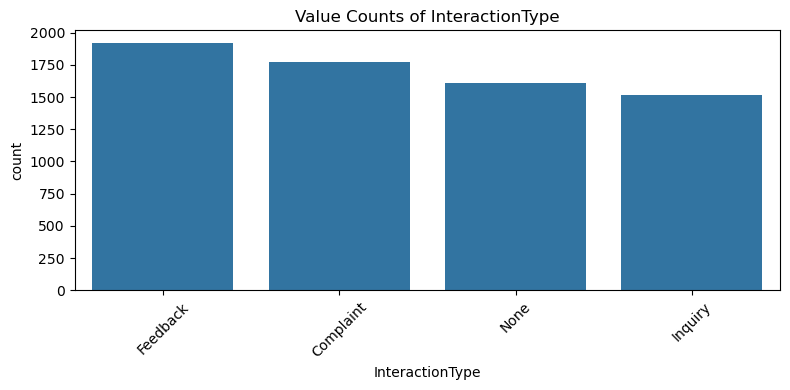

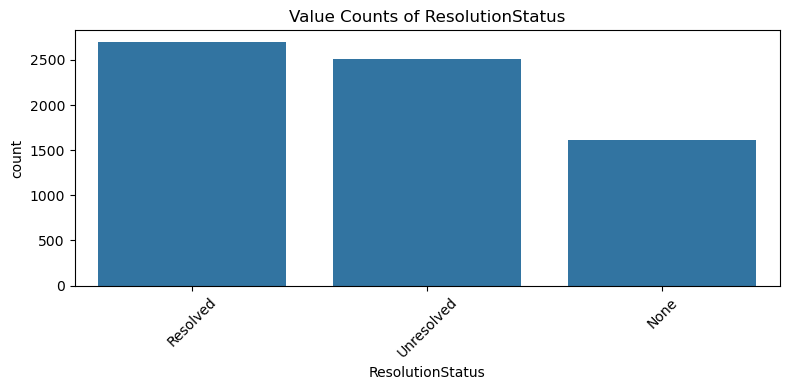

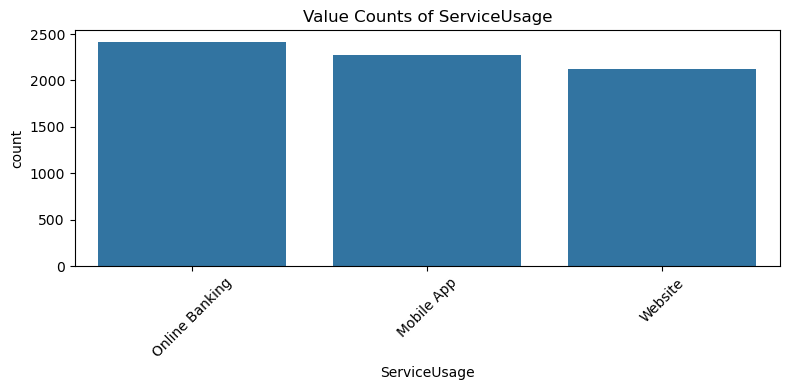

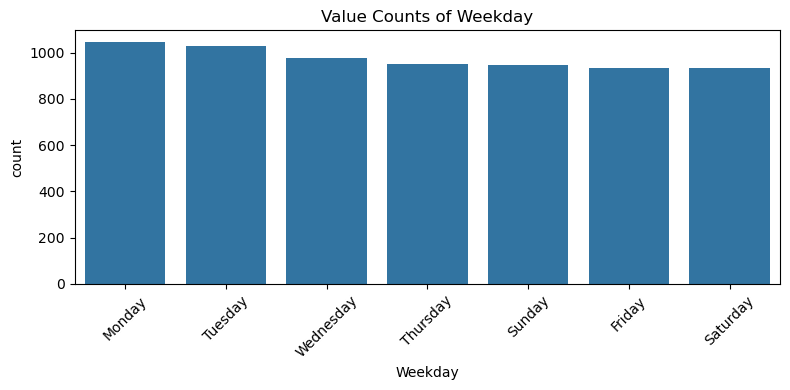

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=col, order=data[col].value_counts().index)
    plt.title(f'Value Counts of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Text(0, 0.5, '')

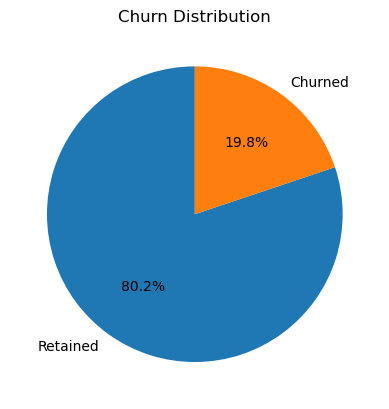

In [23]:
data['ChurnStatus'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, labels=['Retained', 'Churned'])
plt.title('Churn Distribution')
plt.ylabel('')


Text(0.5, 1.0, 'Churn by Resolution Status')

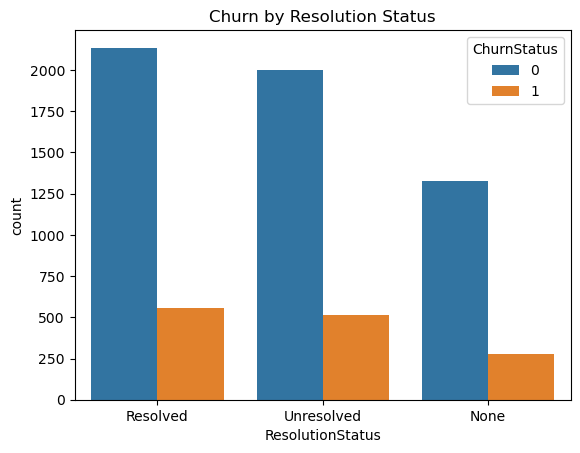

In [24]:
sns.countplot(x='ResolutionStatus', hue='ChurnStatus', data=data)
plt.title('Churn by Resolution Status')


Text(0.5, 1.0, 'Amount Spent vs Churn Status')

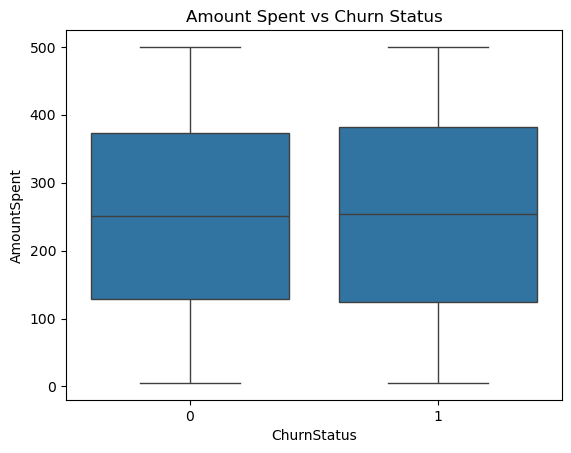

In [25]:
sns.boxplot(x='ChurnStatus', y='AmountSpent', data=data)
plt.title('Amount Spent vs Churn Status')


In [26]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of your data
df_encoded = data.copy()

# List of categorical columns to encode
cat_cols = ['Gender', 'MaritalStatus', 'IncomeLevel', 'ProductCategory',
            'InteractionType', 'ResolutionStatus', 'ServiceUsage']

le = LabelEncoder()

for col in cat_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))  # Convert to str in case of 'None' or NaNs

# Check result
df_encoded[cat_cols].head()


,Gender,MaritalStatus,IncomeLevel,ProductCategory,InteractionType,ResolutionStatus,ServiceUsage
0,1,2,1,2,2,1,0
1,1,1,1,1,2,1,2
2,1,1,1,2,2,1,2
3,1,1,1,3,2,1,2
4,1,1,1,1,2,1,2


In [27]:
# Step 1: Select label-encoded categorical columns
cat_cols = ['Gender', 'MaritalStatus', 'IncomeLevel', 'ProductCategory',
            'InteractionType', 'ResolutionStatus', 'ServiceUsage']

categorical_df = df_encoded[cat_cols]

# Step 2: Select numerical columns (exclude IDs, dates, target)
numerical_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Optional: Drop IDs and target from numeric features
numerical_cols = [col for col in numerical_cols if col not in ['CustomerID', 'TransactionID', 'InteractionID', 'ChurnStatus']]

numerical_df = df_encoded[numerical_cols]

# Step 3: Concatenate
final_features_df = pd.concat([numerical_df, categorical_df], axis=1)

# Step 4: Target variable
target = df_encoded['ChurnStatus']


In [28]:
final_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               6812 non-null   int64  
 1   AmountSpent       6812 non-null   float64
 2   LoginFrequency    6812 non-null   int64  
 3   Gender            6812 non-null   int32  
 4   MaritalStatus     6812 non-null   int32  
 5   IncomeLevel       6812 non-null   int32  
 6   ProductCategory   6812 non-null   int32  
 7   InteractionType   6812 non-null   int32  
 8   ResolutionStatus  6812 non-null   int32  
 9   ServiceUsage      6812 non-null   int32  
dtypes: float64(1), int32(7), int64(2)
memory usage: 346.1 KB


In [29]:
from sklearn.model_selection import train_test_split

X = final_features_df
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# model : rf

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Basic parameter grid to reduce complexity
param_grid = {
    'n_estimators': [30,50, 100],
    'max_depth': [4,5,6 ],
    'min_samples_split': [4, 6,8],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt'],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_rf_low = grid_search.best_estimator_
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred_rf_low = best_rf_low.predict(X_test)
y_prob_rf_low = best_rf_low.predict_proba(X_test)[:, 1]

print(" Random Forest (Limited Complexity) Evaluation:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf_low))
print("Precision:", precision_score(y_test, y_pred_rf_low))
print("Recall   :", recall_score(y_test, y_pred_rf_low))
print("F1 Score :", f1_score(y_test, y_pred_rf_low))
print("ROC AUC  :", roc_auc_score(y_test, y_prob_rf_low))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf_low))


 Random Forest (Limited Complexity) Evaluation:
Accuracy : 0.8415260454878943
Precision: 0.5489130434782609
Recall   : 0.8015873015873016
F1 Score : 0.6516129032258065
ROC AUC  : 0.9135306387781635

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90      1111
           1       0.55      0.80      0.65       252

    accuracy                           0.84      1363
   macro avg       0.75      0.83      0.77      1363
weighted avg       0.88      0.84      0.85      1363



In [32]:
# model : logistics

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
log_reg = LogisticRegression(max_iter=500, random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
y_prob_log = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Evaluation Metrics:")
print("Accuracy :", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall   :", recall_score(y_test, y_pred_log))
print("F1 Score :", f1_score(y_test, y_pred_log))
print("ROC AUC  :", roc_auc_score(y_test, y_prob_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))


Logistic Regression Evaluation Metrics:
Accuracy : 0.5774027879677183
Precision: 0.22542372881355932
Recall   : 0.5277777777777778
F1 Score : 0.3159144893111639
ROC AUC  : 0.5938843884388438

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.59      0.69      1111
           1       0.23      0.53      0.32       252

    accuracy                           0.58      1363
   macro avg       0.54      0.56      0.51      1363
weighted avg       0.73      0.58      0.62      1363



In [35]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [36]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


In [37]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


In [38]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'scale_pos_weight': [1, sum(y_train == 0) / sum(y_train == 1)]  # handle imbalance
}


In [39]:
grid_search_xgb = GridSearchCV(estimator=xgb_clf,
                               param_grid=param_grid,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=1)

grid_search_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\HARSH\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:25:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10], 'n_estimators': [100, 200],
                         'scale_pos_weight': [1, 3.9536363636363636],
                         'subsample': [0.7, 1]},
             scoring='accuracy', verbose=1)

In [40]:
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

print("Best Hyperparameters:", grid_search_xgb.best_params_)
print(" XGBoost Evaluation Metrics:")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall   :", recall_score(y_test, y_pred_xgb))
print("F1 Score :", f1_score(y_test, y_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_test, y_prob_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'scale_pos_weight': 3.9536363636363636, 'subsample': 1}
 XGBoost Evaluation Metrics:
Accuracy : 0.9933969185619956
Precision: 0.9919028340080972
Recall   : 0.9722222222222222
F1 Score : 0.9819639278557114
ROC AUC  : 0.9975640421184976

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1111
           1       0.99      0.97      0.98       252

    accuracy                           0.99      1363
   macro avg       0.99      0.99      0.99      1363
weighted avg       0.99      0.99      0.99      1363



In [41]:
from sklearn.metrics import accuracy_score

# Logistic Regression
train_pred_log = log_reg.predict(X_train)
test_pred_log = log_reg.predict(X_test)

# Random Forest (Limited)
train_pred_rf = best_rf_low.predict(X_train)
test_pred_rf = best_rf_low.predict(X_test)

# XGBoost
train_pred_xgb = best_xgb.predict(X_train)
test_pred_xgb = best_xgb.predict(X_test)

# Accuracy comparison
print("🔍 Accuracy Comparison")

print("\n📘 Logistic Regression:")
print("Train Accuracy:", accuracy_score(y_train, train_pred_log))
print("Test Accuracy :", accuracy_score(y_test, test_pred_log))

print("\n🌲 Random Forest (Tuned):")
print("Train Accuracy:", accuracy_score(y_train, train_pred_rf))
print("Test Accuracy :", accuracy_score(y_test, test_pred_rf))

print("\n⚡ XGBoost:")
print("Train Accuracy:", accuracy_score(y_train, train_pred_xgb))
print("Test Accuracy :", accuracy_score(y_test, test_pred_xgb))


🔍 Accuracy Comparison

📘 Logistic Regression:
Train Accuracy: 0.4890805652413287
Test Accuracy : 0.48495964783565665

🌲 Random Forest (Tuned):
Train Accuracy: 0.8665810240411085
Test Accuracy : 0.8415260454878943

⚡ XGBoost:
Train Accuracy: 1.0
Test Accuracy : 0.9933969185619956


C:\Users\HARSH\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\HARSH\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [42]:
from sklearn.metrics import accuracy_score

# Predictions
train_pred_log = log_reg.predict(X_train)
test_pred_log = log_reg.predict(X_test)

train_pred_rf = best_rf_low.predict(X_train)
test_pred_rf = best_rf_low.predict(X_test)

train_pred_xgb = best_xgb.predict(X_train)
test_pred_xgb = best_xgb.predict(X_test)

# Accuracy values
train_acc = [
    accuracy_score(y_train, train_pred_log),
    accuracy_score(y_train, train_pred_rf),
    accuracy_score(y_train, train_pred_xgb)
]

test_acc = [
    accuracy_score(y_test, test_pred_log),
    accuracy_score(y_test, test_pred_rf),
    accuracy_score(y_test, test_pred_xgb)
]

models = ['Logistic Regression', 'Random Forest', 'XGBoost']


C:\Users\HARSH\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\HARSH\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


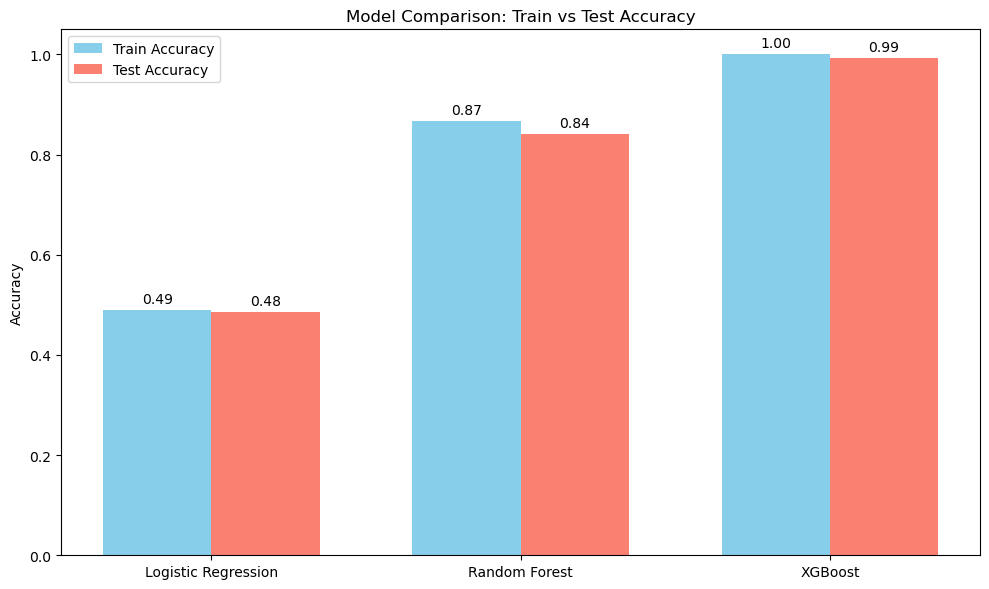

In [43]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(models))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, train_acc, width, label='Train Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, test_acc, width, label='Test Accuracy', color='salmon')

# Labels and formatting
ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison: Train vs Test Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.05)
ax.legend()

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [44]:
import joblib
joblib.dump(best_rf_low, r"C:\Users\HARSH\Desktop\Streamlit\Fraud Analysis\Churn\best_rf_low.joblib")

['C:\\Users\\HARSH\\Desktop\\Streamlit\\Fraud Analysis\\Churn\\best_rf_low.joblib']